In [1]:
!pip install -qq git+https://www.github.com/keras-team/keras-contrib.git

In [2]:
# example of using saved cyclegan models for image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
import numpy as np

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,1] to [-1,1]
	X1 = (X1 * 2.0) - 1.0
	X2 = (X2 * 2.0) - 1.0
	return [X1, X2]

# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	print(ix)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	images = np.squeeze(images)
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i], cmap='gray')
		# title
		pyplot.title(titles[i])
	pyplot.show()

Loaded (81, 256, 256, 1) (82, 256, 256, 1)
-0.99951171875 0.9999916289628605
[26]
-0.99951171875 0.9997816956755652
-0.99999976 0.99999887


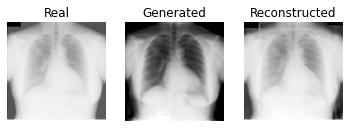

[73]


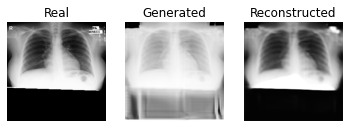

In [3]:
# load dataset
A_data, B_data = load_real_samples('../input/cycleganunet-200epoch-outputs/cyclegan_CXR_train.npz')
print('Loaded', A_data.shape, B_data.shape)
print(A_data.min(), A_data.max())
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('../input/cycleganunet-200epoch-outputs/g_model_AtoB.h5', cust)
model_BtoA = load_model('../input/cycleganunet-200epoch-outputs/g_model_BtoA.h5', cust)
# plot A->B->A
A_real = select_sample(A_data, 1)
print(A_real.min(), A_real.max())
B_generated  = model_AtoB.predict(A_real)
print(B_generated.min(), B_generated.max())
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

In [4]:
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import os
import numpy as np
from skimage import io, exposure
from skimage.filters import laplace
from skimage.transform import resize
import cv2

# define location of dataset for Main lung CXR images
folder1 = '../input/cycleganunet-200epoch-outputs/'

#Load all the chest Xrays from respective datasets
jsrt_CXR = np.load(folder1 + 'jsrt_CXR_test.npy')
jsrt_CXR = (jsrt_CXR * 2) - 1
print(jsrt_CXR.shape, jsrt_CXR.min(), jsrt_CXR.max())

(165, 256, 256, 1) -0.99951171875 1.0000000000000009


In [5]:
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import os
import numpy as np
from skimage import io, exposure
from skimage.filters import laplace
from skimage.transform import resize
import cv2

# define location of dataset for Main lung CXR images
folder1 = '../input/cycleganunet-200epoch-outputs/'

#Load all the chest Xrays from respective datasets
jsrt_CXR = np.load(folder1 + 'jsrt_CXR_test.npy')
#convert array from [0,1] to [-1,1] as input for GAN inference
jsrt_CXR = (jsrt_CXR * 2) - 1
print(jsrt_CXR.shape, jsrt_CXR.min(), jsrt_CXR.max())

jsrt_GAN_CXR=[]
for i in range(0,(jsrt_CXR.shape[0])):
    A_real = jsrt_CXR[[i]]
    B_generated  = model_AtoB.predict(A_real)
    jsrt_GAN_CXR.append(B_generated[0])

from numpy import asarray    
jsrt_GAN_CXR=asarray(jsrt_GAN_CXR)
# convert from [-1,1] to [0,1] for UNET inference
jsrt_GAN_CXR=(jsrt_GAN_CXR+1)/2
print(jsrt_GAN_CXR.shape, jsrt_GAN_CXR.min(), jsrt_GAN_CXR.max())

(165, 256, 256, 1) -0.99951171875 1.0000000000000009
(165, 256, 256, 1) 0.0 1.0


In [6]:
print(jsrt_GAN_CXR.shape)
save('jsrt_GAN_CXR.npy', jsrt_GAN_CXR)

from sklearn.model_selection import train_test_split

jsrt_CXR_Mask = np.load('../input/jsrt-data/CXR_Mask.npy')
# Split into train and test data(67%)
X=np.arange(0,246)
X_train, X_test = train_test_split(X, test_size=0.67, random_state=999)
jsrt_CXR_GAN_Mask = jsrt_CXR_Mask[X_test]
print(jsrt_CXR_GAN_Mask.shape)


(165, 256, 256, 1)
(165, 256, 256, 1)


In [7]:
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import os
import numpy as np
from skimage import io, exposure
from skimage.filters import laplace
from skimage.transform import resize
import cv2

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from skimage import morphology, color, io, exposure
from skimage import transform, io, img_as_float, exposure

#Inference with GAN generated jsrt images (jsrt translated to montgomery like images)
#jsrt_CXR = np.load('../input/jsrt-data/CXR.npy')
#jsrt_CXR_Mask = np.load('../input/jsrt-data/CXR_Mask.npy')
CXR_test, CXR_Mask_test = jsrt_GAN_CXR, jsrt_CXR_GAN_Mask

#========================================BUILD UNET MODEL=============================================
from keras.models import Model
from keras.layers.merge import concatenate
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D


def UNET(inp_shape, k_size=3):
    merge_axis = -1 # Feature maps are concatenated along last axis (for tf backend)
    data = Input(shape=inp_shape)
    conv1 = Convolution2D(filters=32, kernel_size=k_size, padding='same', activation='relu')(data)
    conv1 = Convolution2D(filters=32, kernel_size=k_size, padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(pool1)
    conv2 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(pool2)
    conv3 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(pool3)
    conv4 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(pool4)

    up1 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up1)
    conv6 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv6)
    merged1 = concatenate([conv4, conv6], axis=merge_axis)
    conv6 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged1)

    up2 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up2)
    conv7 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv7)
    merged2 = concatenate([conv3, conv7], axis=merge_axis)
    conv7 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged2)

    up3 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(up3)
    conv8 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv8)
    merged3 = concatenate([conv2, conv8], axis=merge_axis)
    conv8 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(merged3)

    up4 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(up4)
    conv9 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv9)
    merged4 = concatenate([conv1, conv9], axis=merge_axis)
    conv9 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(merged4)

    conv10 = Convolution2D(filters=1, kernel_size=k_size, padding='same', activation='sigmoid')(conv9)

    output = conv10
    model = Model(data, output)
    return model
    


import pandas as pd
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# Build model
inp_shape = CXR_test[0].shape
UNet = UNET(inp_shape)
UNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#UNet.summary()

def Dice(y_true, y_pred):
    """Returns Dice Similarity Coefficient for ground truth and predicted masks."""
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    return (2. * intersection + 1.) / (y_true.sum() + y_pred.sum() + 1.)

def masked(img, gt, mask, alpha=1):
    """Returns image with GT lung field outlined with red, predicted lung field
    filled with blue."""
    rows, cols = img.shape
    color_mask = np.zeros((rows, cols, 3))
    #convert to numpy float and then subtract
    #boundary = morphology.dilation(gt, morphology.disk(3)) - gt
    a1 = morphology.dilation(gt, morphology.disk(3))
    a2 = gt
    a1 = a1.astype(np.float32)
    a2 = a2.astype(np.float32)
    boundary = a1 - a2
    
    color_mask[mask == 1] = [1, 0, 0]         #predicted mask - Red color area
    color_mask[boundary == 1] = [0, 0, 1]     # Actual mask - Ground truth - Blue curve
    img_color = np.dstack((img, img, img))

    img_hsv = color.rgb2hsv(img_color)
    color_mask_hsv = color.rgb2hsv(color_mask)

    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

    img_masked = color.hsv2rgb(img_hsv)
    return img_masked

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img


# For inference standard keras ImageGenerator is used.
test_gen = ImageDataGenerator(rescale=1.)

n_test = CXR_test.shape[0]
dices = np.zeros(n_test)
im_shape = (256, 256)

i = 0
count=0
for xx, yy in test_gen.flow(CXR_test, CXR_Mask_test, batch_size=1, seed=999):
    count=count+1
    img = np.squeeze(xx)
    UNet.load_weights('../input/kfold-unet-ver0/UNET_1.h5')
    pred1 = UNet.predict(xx)[..., 0].reshape(inp_shape[:2])
    UNet.load_weights('../input/kfold-unet-ver0/UNET_2.h5')
    pred2 = UNet.predict(xx)[..., 0].reshape(inp_shape[:2])
    UNet.load_weights('../input/kfold-unet-ver0/UNET_3.h5')
    pred3 = UNet.predict(xx)[..., 0].reshape(inp_shape[:2])
    UNet.load_weights('../input/kfold-unet-ver0/UNET_4.h5')
    pred4 = UNet.predict(xx)[..., 0].reshape(inp_shape[:2])
    UNet.load_weights('../input/kfold-unet-ver0/UNET_5.h5')
    pred5 = UNet.predict(xx)[..., 0].reshape(inp_shape[:2])
    pred = (pred1 + pred2 + pred3 + pred4 + pred5)/5.0
    mask = yy[..., 0].reshape(inp_shape[:2])

    # Binarize masks
    gt = mask > 0.5
    pr = pred > 0.5

    # Remove regions smaller than 2% of the image
    pr = remove_small_regions(pr, 0.02 * np.prod(im_shape))

    #io.imsave('./'+str(count), masked(img, gt, pr, 1))
    export_path = '../working/'
    image_filename = str(count) + str('.png')
    io.imsave(os.path.join(export_path, image_filename), masked(img, gt, pr, 1)) 

    dices[i] = Dice(gt, pr)
    print(str(count), dices[i])

    i += 1
    if i == n_test:
        break

print('Mean Dice:', dices.mean())

1 0.9666381189660542
2 0.9730813135469484
3 0.9711159085833395
4 0.9606221602519412
5 0.9677474071920131
6 0.9594180493056897
7 0.9564396587889805
8 0.9559781257767835
9 0.9517643540669857
10 0.9618999138538649
11 0.9517689572769132
12 0.9597358722358722
13 0.950917406217673
14 0.9755498612000855
15 0.9660243622936208
16 0.8990203710912158
17 0.96621518794704
18 0.9687817655797951
19 0.9708445815657539
20 0.9635564805179789
21 0.2592922543924771
22 0.9779743493764652
23 0.9126495673091943
24 0.967554834551879
25 0.958283414739041
26 0.9611935431273438
27 0.9672658133563322
28 0.9467785219764112
29 0.9695401449061067
30 0.9582272572980313
31 0.38061753614079197
32 0.9533655144477451
33 0.9749330556382029
34 0.9578675586069302
35 0.9735439417576703
36 0.9006224229850041
37 0.9413780903100261
38 0.9353141319829087
39 0.9755557183139855
40 0.9648958577112099
41 0.9651259093452714
42 0.9677348390408448
43 0.9676840215439856
44 0.9754129850172878
45 0.8927154195011338
46 0.9149175646664026
4